<a href="https://colab.research.google.com/github/Sarah-Xu-08/raclette-group-1/blob/main/XX_single_c%26w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.io
import os
from matplotlib import pyplot as plt
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# try for bp first!!!
data_dir = '/content/drive/MyDrive/NMA-project/data'
pat = 'wm'
alldat = scipy.io.loadmat(data_dir + '/' + pat + '/' + pat +'_fingerflex.mat')
allresp = scipy.io.loadmat(data_dir + '/' + pat + '/' + pat +'_stim.mat')
alldat['resp'] = allresp['stim']

In [ ]:
print('alldat:', alldat.keys())
print('allresp:', allresp.keys())

alldat: dict_keys(['__header__', '__version__', '__globals__', 'data', 'elec_regions', 'flex', 'brain', 'locs', 'cue', 'resp'])
allresp: dict_keys(['__header__', '__version__', '__globals__', 'stim'])


In [ ]:
print(alldat['__header__'])
print(alldat['__version__'])
print(alldat['__globals__'])
print('data:', type(alldat['data']), alldat['data'].shape)
print('elec_regions:', type(alldat['elec_regions']),alldat['elec_regions'].shape)
print('flex:', type(alldat['flex']),alldat['flex'].shape)
print('brain:', type(alldat['brain']),alldat['brain'].shape)
print('locs:', type(alldat['locs']),alldat['locs'].shape)
print('cue:', type(alldat['cue']),alldat['cue'].shape)
print('response:', type(alldat['resp']),alldat['resp'].shape)

b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Jan  4 09:06:30 2016'
1.0
[]
data: <class 'numpy.ndarray'> (444840, 38)
elec_regions: <class 'numpy.ndarray'> (38, 1)
flex: <class 'numpy.ndarray'> (444840, 5)
brain: <class 'numpy.ndarray'> (1, 1)
locs: <class 'numpy.ndarray'> (38, 3)
cue: <class 'numpy.ndarray'> (444840, 1)
response: <class 'numpy.ndarray'> (444840, 1)


Variables are: 
* `alldat['data']`: continuous voltage data (time by channels)
* `alldat['elec_regions']`: A numerical code for the anatomical location of the associated  channel
* `alldat['flex']`:  These are the finger flexions. Note that they are in the raw form input. They are in 40ms blocks, and have non-zero offset. The 5 columns correspond to the digits thumb-index-middle-ring-little in order. 
* `alldat['brain']`: This is a structure representing the tessellated brain surface.
* `alldat['locs']`: three-dimensional coordinates of the electrodes (n_channels by 3)
* `alldat['cue']`: cue identity (which finger to flex)
* `alldat['resp']`: response identity (which finger flexes the most)


///////////////////////////// NEEDED to decide the range of trails /////////////////////////////////
* `alldat['t_on']`: time of cue onset 
* `alldat['t_off']`: time of cue offset (usually 2000ms after `t_on`) 

(444840, 5)


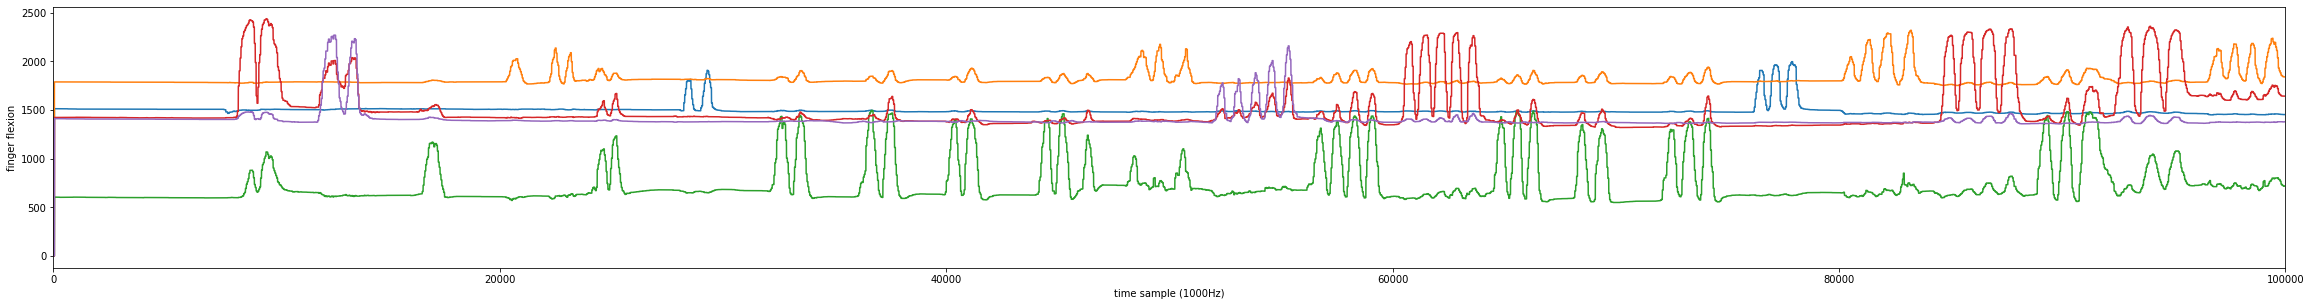

In [ ]:
# finger data from the dataglove
dg = alldat['flex']
nfingers = dg.shape[1]
print(dg.shape)

for j in range(dg.shape[-1]):
  plt.plot(dg[:100000, j])

plt.xlabel('time sample (1000Hz)')
plt.ylabel('finger flexion')
plt.xlim([0, 100000])
plt.show()

In [ ]:
resp = alldat['resp']
resp[resp == -1] = 0
resp[resp == -2] = 0

cue = alldat['cue']
np.unique(cue)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

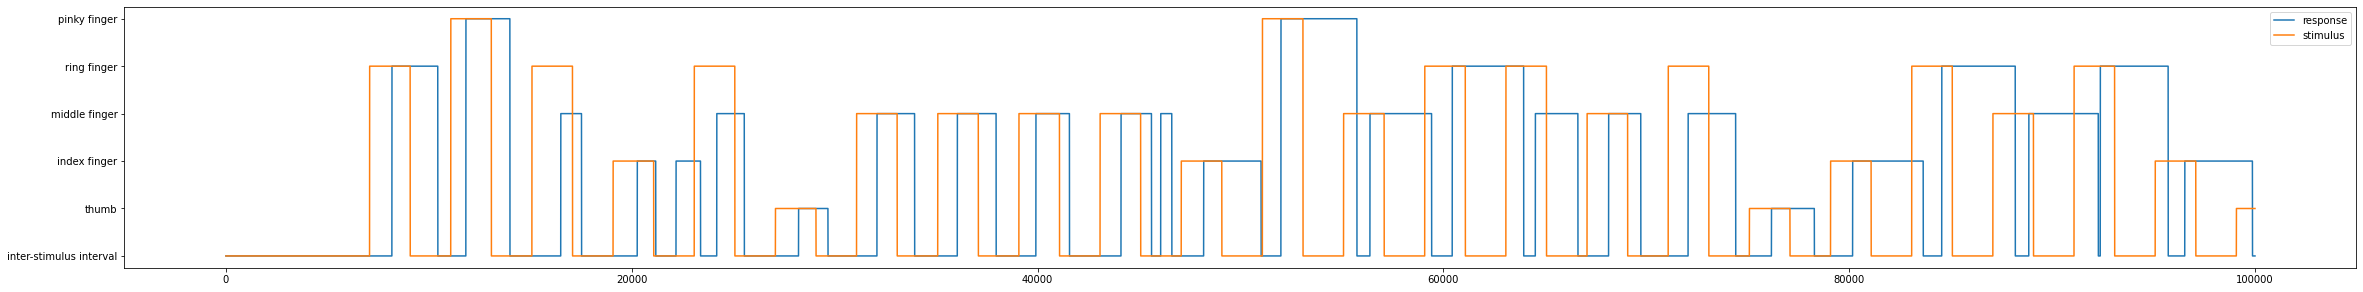

In [ ]:
plt.plot(resp[:100000,:])
plt.plot(cue[:100000,:])
plt.rcParams["figure.figsize"] = (40, 4.8)

plt.legend(['response', 'stimulus'])
plt.yticks([0,1,2,3,4,5],['inter-stimulus interval','thumb','index finger','middle finger','ring finger','pinky finger'])
plt.show()

In [ ]:
# trails extraction (based on the one-to-one corresponding relation of each response and stimuli)
def trail_extract(cue, resp):

  last_t = 0

  for i in range(0, len(cue)):

    if i == 0:
      cue_mat = np.array([cue[0,0],0,0])
      resp_mat = np.array([resp[0,0]])
      
    elif cue[i] != cue[i-1]:
      if cue[i-1] != 0:
        last_cue = np.array([cue[i-1,0],last_t,i-1])
        last_t = i

        if i+2000 < len(resp):
          for t in range(i,i+2000):
            if resp[t] != 0:
              this_resp = np.array([resp[t,0]])
              resp_mat = np.vstack((resp_mat, this_resp))
              cue_mat = np.vstack((cue_mat, last_cue))
              break

  return cue_mat[1:,:], resp_mat[1:,:]

cue_mat, resp_mat = trail_extract(cue, resp)

In [ ]:
print(cue_mat.shape, resp_mat.shape)
print(cue_mat[:5,:])
print(resp_mat[:5,:])

(81, 3) (81, 1)
[[    4     0  9079]
 [    5  9080 13079]
 [    4 13080 17079]
 [    2 17080 21079]
 [    4 21080 25079]]
[[4]
 [5]
 [3]
 [2]
 [3]]


In [ ]:
# correct & wrong extraction
a = 0

print(cue_mat.shape)
print(resp_mat.shape)

for i in range(0,resp_mat.shape[0]):
  if cue_mat[i,0] != resp_mat[i,0]:
    a += 1

print(a)
print(resp_mat.shape[0])
print(a/resp_mat.shape[0])

(81, 3)
(81, 1)
16
81
0.19753086419753085


**It is hard to visualize but we could choose electrodes based on its regions roughly.**

In [ ]:
# # Code to read data file into Colaboratory:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# # @title Install packages (`nilearn`, `nimare`, `duecredit`), import `matplotlib` and set defaults
# # install packages to visualize brains and electrode locations
# !pip install nilearn --quiet
# !pip install nimare --quiet
# !pip install duecredit --quiet

# from matplotlib import rcParams
# from matplotlib import pyplot as plt

# rcParams['figure.figsize'] = [20, 4]
# rcParams['font.size'] = 15
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# rcParams['figure.autolayout'] = True

In [ ]:
# from nilearn import plotting
# from nimare import utils

# plt.figure(figsize=(8, 8))
# locs = alldat['locs']
# print(locs.shape)
# view = plotting.view_markers(utils.tal2mni(locs),
#                              marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
#                              marker_color='purple',
#                              marker_size=5)
# view